# Random Circuits Experiment
### Description
This notebook demonstrates an experiment for analyzing Amplitude-Damping noises in compare to approximation with relaxation noises.<br>
We will generate CIRCUITS_NUM circuits with QUBITS_NUM qubits and GATES_NUM random gates.



In [1]:
NAME = 'RandomCircuits'
SEED = 1
SHOTS = 5000
NUM_INTERVALS = 100
QUBITS_NUM = 5
GATES_NUM = 10
CIRCUITS_NUM = 5
GATES = ['h', 'x', 'y', 'z', 's']

In [5]:
import numpy as np
import operator
from project_common import *
import matplotlib.pyplot as plt

# Gamma intervals for the experiment
gamma_range = np.linspace(0, 1, num=NUM_INTERVALS, dtype=float, endpoint=False)

def create_qobj():
    qobj = create_basic_qobj(name=NAME, shots=SHOTS, seed=SEED)
    qobj['circuits'], circuit_drawers = generate_random_circuits(QUBITS_NUM,
                                                                       GATES_NUM,
                                                                       CIRCUITS_NUM,
                                                                       GATES)
      
    return qobj, circuit_drawers

def do_metric(sim1_results, sim2_results, circuit_drawers, experiment_type):
    results_frob = [[] for _ in range(CIRCUITS_NUM)]
    metric_func = {
        ExperimentType.WITH_CLIFFORD: metric_fro_exact_clifford,
        ExperimentType.EXACT_ONLY: metric_fro_exact_exact
    }[experiment_type]
    
    for res1, res2 in zip(sim1_results, sim2_results):
        for i in range(CIRCUITS_NUM):
                results_frob[i].append(metric_func(res1, res2, i, QUBITS_NUM))
            
    # Calculate maximum, minimum and average
    results_max = []
    results_min = []
    results_avg = []
    for frob_res in results_frob:
        # Max
        index, value = max(enumerate(frob_res), key=operator.itemgetter(1))
        results_max.append((gamma_range[index], value))

        # Min
        index, value = min(enumerate(frob_res), key=operator.itemgetter(1))
        results_min.append((gamma_range[index], value))

        # Average
        results_avg.append(np.mean(frob_res))
    return {'fro': results_frob, 'max': results_max,
            'min': results_min, 'avg': results_avg}

def execute_experiment():
    # Create qobj with random circuits
    qobj, circuit_drawers = create_qobj()
    
    # Run experiment exact-only
    res1_exact_only, res2_exact_only = run_experiment(qobj, gamma_range,
                                                      ExperimentType.EXACT_ONLY)
    
    # Run experiment with Clifford
    res1_with_clifford, res2_with_clifford = run_experiment(qobj, gamma_range,
                                                      ExperimentType.WITH_CLIFFORD)
    
    # Calculate metric of the two experiments
    exact_only_metric = do_metric(res1_exact_only, res2_exact_only,
                                  circuit_drawers, ExperimentType.EXACT_ONLY)
    with_clifford_metric = do_metric(res1_with_clifford, res2_with_clifford, 
                                     circuit_drawers, ExperimentType.WITH_CLIFFORD)
    
    return exact_only_metric, with_clifford_metric, qobj, circuit_drawers


def plot_results2(res_exact, res_clifford, circuit_drawers):
    plt.rcParams['figure.figsize'] = [20, 90]
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    for i in range(CIRCUITS_NUM):
        textstr = 'MAX (exact_only) = (Gamma=%.3f, frob=%.3f)\n' \
          'MAX (with clifford) = (Gamma=%.3f, frob=%.3f)\n' \
          'MIN (exact_only) = (Gamma=%.3f, frob=%.3f)\n' \
          'MIN (with clifford) = (Gamma=%.3f, frob=%.3f)\n' \
          'AVG (exact_only) = %.3f\n' \
          'AVG (with clifford) = %.3f' % (*res_exact['max'][i],
                                                    *res_clifford['max'][i],
                                                    *res_exact['min'][i],
                                                    *res_clifford['min'][i],
                                                    res_exact['avg'][i],
                                                    res_clifford['avg'][i],)
        ax = plt.subplot(len(circuit_drawers)*2, 2, i*2+1)
        ax.set_title('Circuit %d' % i, fontsize=20)
        plt.imshow(circuit_drawers[i])
        plt.axis('off')
        ax = plt.subplot(len(circuit_drawers)*2, 2, i*2+2)
        ax.text(0.02, 0.85, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
        plt.plot(gamma_range, res_exact['fro'][i])
        plt.plot(gamma_range, res_clifford['fro'][i])
        plt.legend(['EXACT ONLY', 'WITH CLIFFORD'], loc='best', prop={'size': 14})
        if i == CIRCUITS_NUM//2:
            plt.ylabel('Frobenius Norm of matrices difference', fontsize=16)
    plt.xlabel('Gamma', fontsize=16)

In [3]:
# Create qobj with increasing number of qubits (random base circuit)
res_exact, res_clifford, qobj, circuit_drawers = execute_experiment()


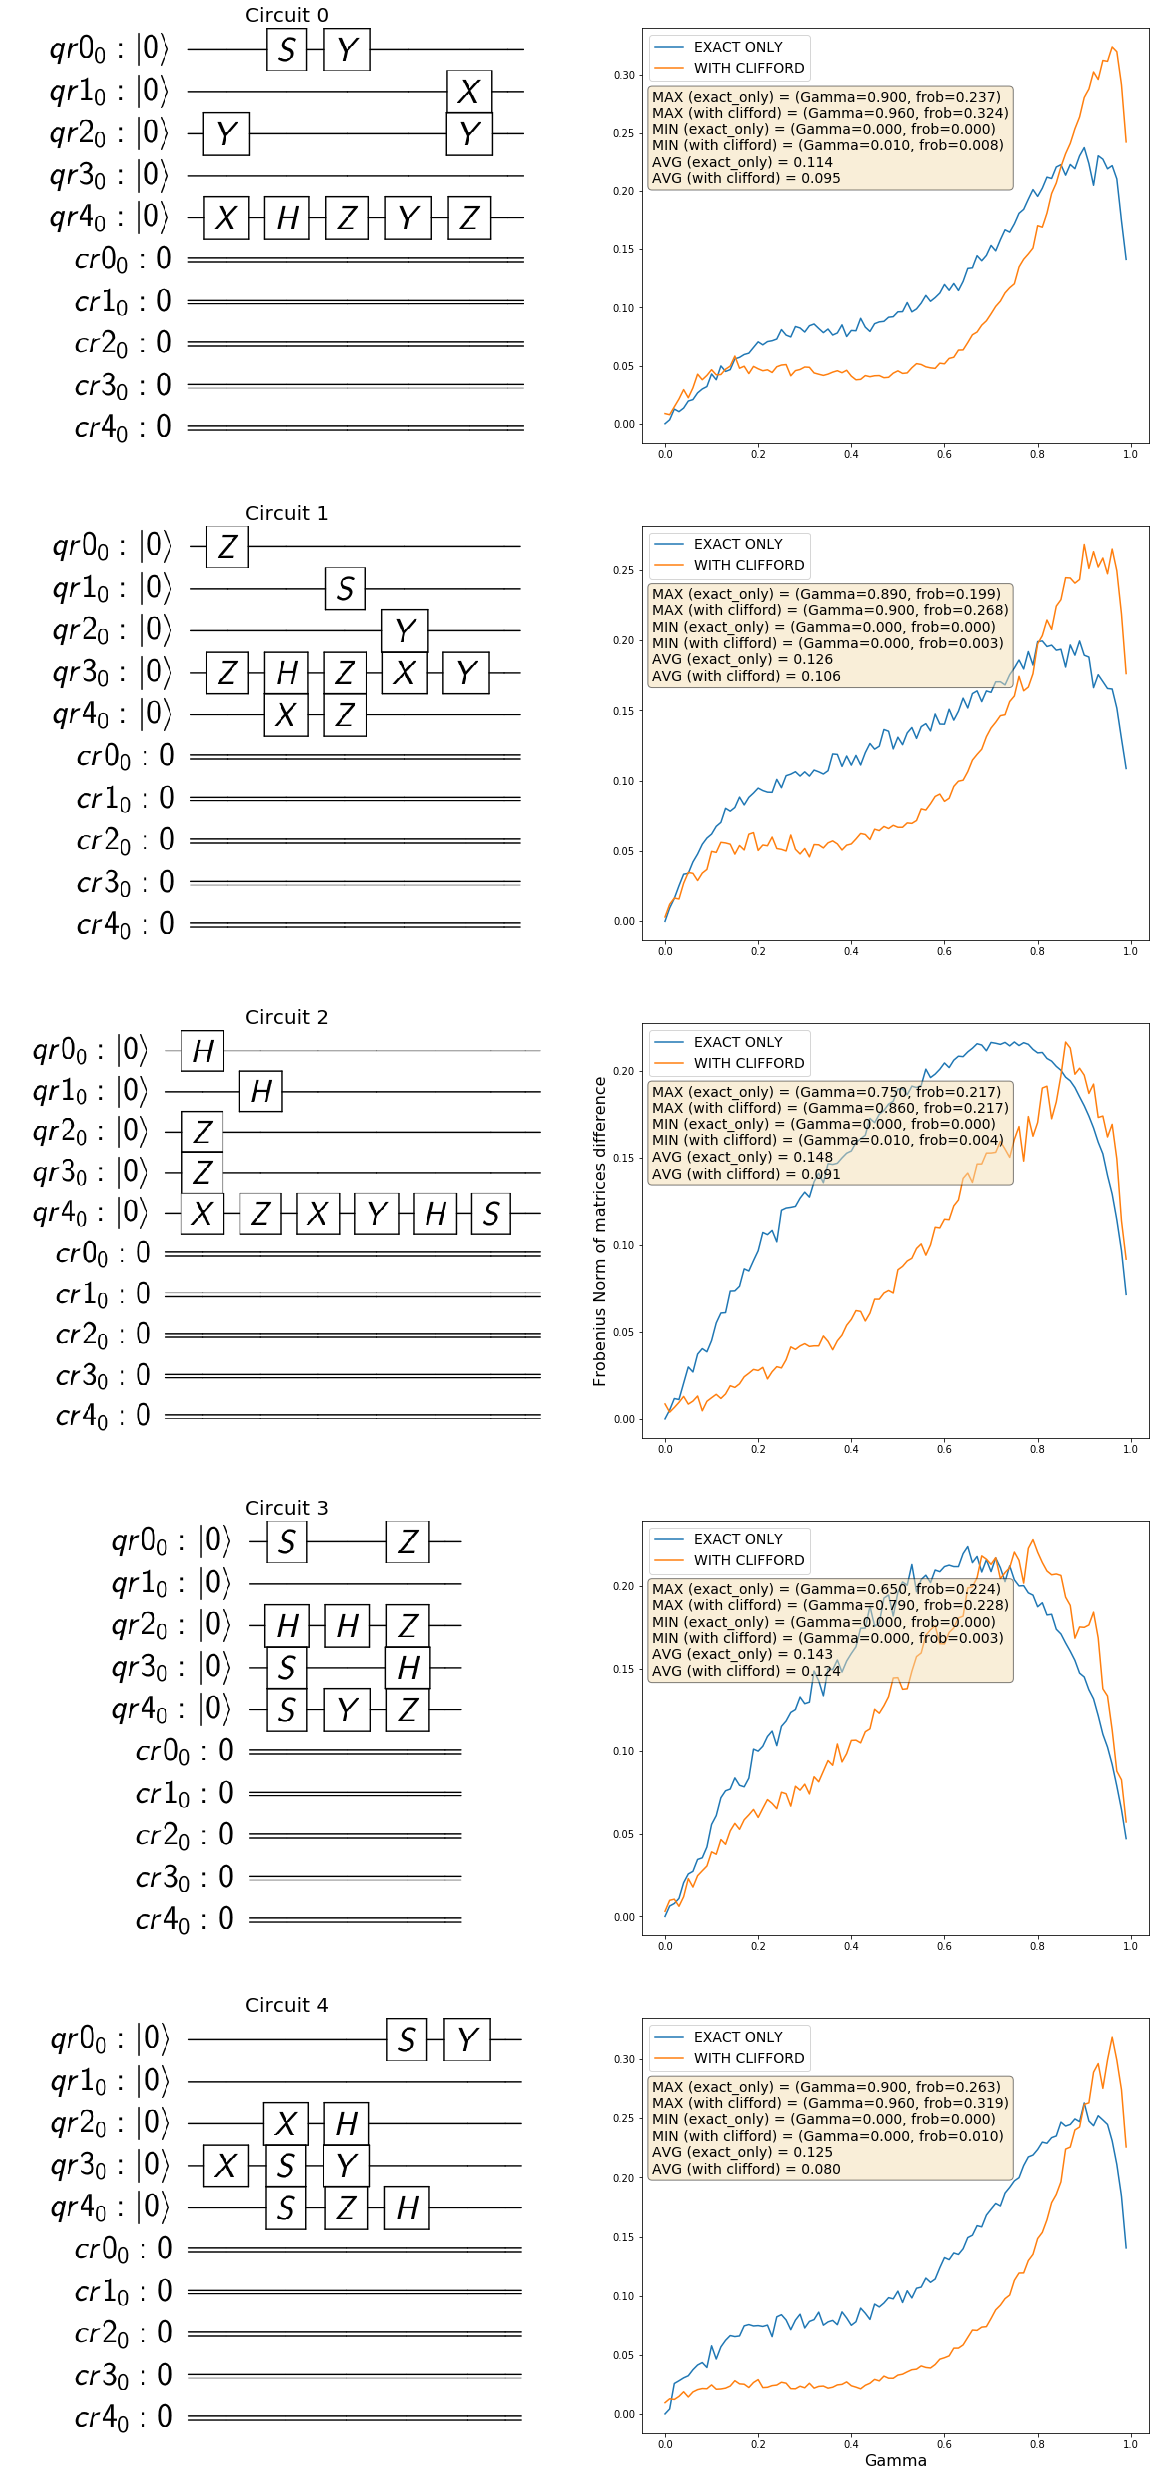

In [6]:
%matplotlib inline
plot_results2(res_exact, res_clifford, circuit_drawers)